### Simple model without horizon and location
$y_t \mid \varepsilon_t = \theta + \sum_{p=1} \phi_p y_{t-p} + \varepsilon_t, \\
\varepsilon_t \sim N(0, \sigma_{\eta}) $


In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['MPLBACKEND'] = 'TKAgg'

import numpy as np
import pandas as pd
import matplotlib
# matplotlib.use('TkAgg')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import date

import jax
import jax.numpy as jnp

import arviz as az


In [2]:
from arhdfa_l1h1 import ARHDFA

In [3]:
os.getcwd()

'/Users/dk29776/Dropbox/epi/Comparing-Forecast-Performance/DFA'

In [4]:
def loaddata(model1, model2, val, mean_axis):
    mypath = f'/Users/dk29776/Dropbox/epi/Comparing-Forecast-Performance/Data/death_diff_scores/{model1}_{model2}.csv'
    df = pd.read_csv(mypath)
    lix = pd.MultiIndex.from_product([np.unique(df.location), np.unique(df.relative_horizon)])
    df_pivot = (df.pivot_table(val, 'reference_date', ['location', 'relative_horizon'], aggfunc='first')).reindex(lix, axis=1)
    mydf = jnp.array(df_pivot.groupby(level=0, axis=1).agg(lambda x: [*x.values]).to_numpy().tolist())
    if model1 == 'COVIDhub-baseline' or model2 == 'COVIDhub-baseline':
        indices_to_change = [(38, 13), (21, 24), (24, 41)]
        for index in indices_to_change:
            mydf = mydf.at[index[0], index[1], :].set(np.nan) 
        print(mydf[38,13,:])
    if mean_axis == 'location':
        mydf_mean = np.mean(mydf, axis=1)
        mydf_reshape = mydf_mean.reshape(mydf_mean.shape[0],1,mydf_mean.shape[1])
    elif mean_axis == 'horizon':
        mydf_mean = np.mean(mydf, axis=2)
        mydf_reshape = mydf_mean.reshape(mydf_mean.shape[0],mydf_mean.shape[1],1)
    elif mean_axis == 'both':
        mydf_mean = np.mean(mydf, axis=(1,2))
        mydf_reshape = mydf_mean.reshape(mydf_mean.shape[0],1,1)
    else:  mydf_reshape = mydf[:,0,0].reshape(mydf.shape[0],1,1)

    return mydf_reshape

In [5]:
def dfa_ftn(model1, model2, val, mean_axis, p=1, q=1, sigma_type = 'constant', 
            ar_constraint='[0,1]', ar_var_constraint='[0,1]'):
    obs = loaddata(model1, model2, val, mean_axis)
    # Define a DFA model with specified parameter values to use for data generation
    dfa_model = ARHDFA(num_timesteps=obs.shape[0], num_series=obs.shape[1], num_horizons=obs.shape[2], 
                        p=p, q=q, ar_constraint=ar_constraint, sigma_type=sigma_type,
                        ar_var_constraint=ar_var_constraint)
    mcmc_samples = dfa_model.fit(y=obs,
                             rng_key=jax.random.PRNGKey(79942),
                             num_warmup=5000,
                             num_samples=5000,
                             thinning = 1,
                             num_chains=3)
    dfa_model.mcmc.print_summary()
    waic = az.waic(az.from_numpyro(mcmc_samples))
    print(waic)
    az.plot_pair(az.from_numpyro(mcmc_samples),
            #var_names=['intercept', 'alpha', 'phi','ARVar_mu'],
            divergences=True,
            colorbar=True)
    az.plot_trace(az.from_numpyro(mcmc_samples))




/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_77699/3263566727.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mydf = jnp.array(df_pivot.groupby(level=0, axis=1).agg(lambda x: [*x.values]).to_numpy().tolist())


[nan nan nan nan]


/Users/dk29776/Dropbox/epi/Comparing-Forecast-Performance/DFA/arhdfa_l1h1.py:357: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 10000/10000 [00:01<00:00, 6065.17it/s, 7 steps of size 3.06e-01. acc. prob=0.88]



MCMC elapsed time: 10.571392059326172

                          mean       std    median      5.0%     95.0%     n_eff     r_hat
            ARVar_mu      1.11      1.03      1.12     -0.58      2.80  19510.02      1.00
        intercept[0]      3.91      1.02      3.91      2.18      5.54   9354.19      1.00
    log_sigma_eps[0]      4.49      0.14      4.49      4.26      4.72  19639.08      1.00
log_sigma_eta_t[0,0]      4.03      0.35      4.02      3.46      4.60   5177.25      1.00
   log_sigma_nu[0,0]      1.08      0.80      1.11     -0.30      2.34  15887.40      1.00
         ms_t[0,0,0]    -23.67      1.47    -23.66    -26.09    -21.27  11604.09      1.00
         ms_t[1,0,0]    -18.03      5.37    -18.10    -26.66     -9.05  19112.12      1.00
         ms_t[2,0,0]    -18.40      5.78    -18.45    -27.98     -9.16  15659.10      1.00
         ms_t[3,0,0]    -21.58      5.83    -21.62    -31.20    -12.04  15793.44      1.00
         ms_t[4,0,0]    -25.68      5.91    -25.67

/Users/dk29776/miniconda3/envs/forecastskill/lib/python3.10/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 15000 posterior samples and 117 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -433.88     6.28
p_waic        7.81        -

There has been a warning during the calculation. Please check the results.


/Users/dk29776/miniconda3/envs/forecastskill/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: title={'center': 'ARVar_mu'}>,
        <Axes: title={'center': 'ARVar_mu'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'log_sigma_eps'}>,
        <Axes: title={'center': 'log_sigma_eps'}>],
       [<Axes: title={'center': 'log_sigma_eta_t'}>,
        <Axes: title={'center': 'log_sigma_eta_t'}>],
       [<Axes: title={'center': 'log_sigma_nu'}>,
        <Axes: title={'center': 'log_sigma_nu'}>],
       [<Axes: title={'center': 'ms_t'}>,
        <Axes: title={'center': 'ms_t'}>],
       [<Axes: title={'center': 'mu_0'}>,
        <Axes: title={'center': 'mu_0'}>],
       [<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>]],
      dtype=object)

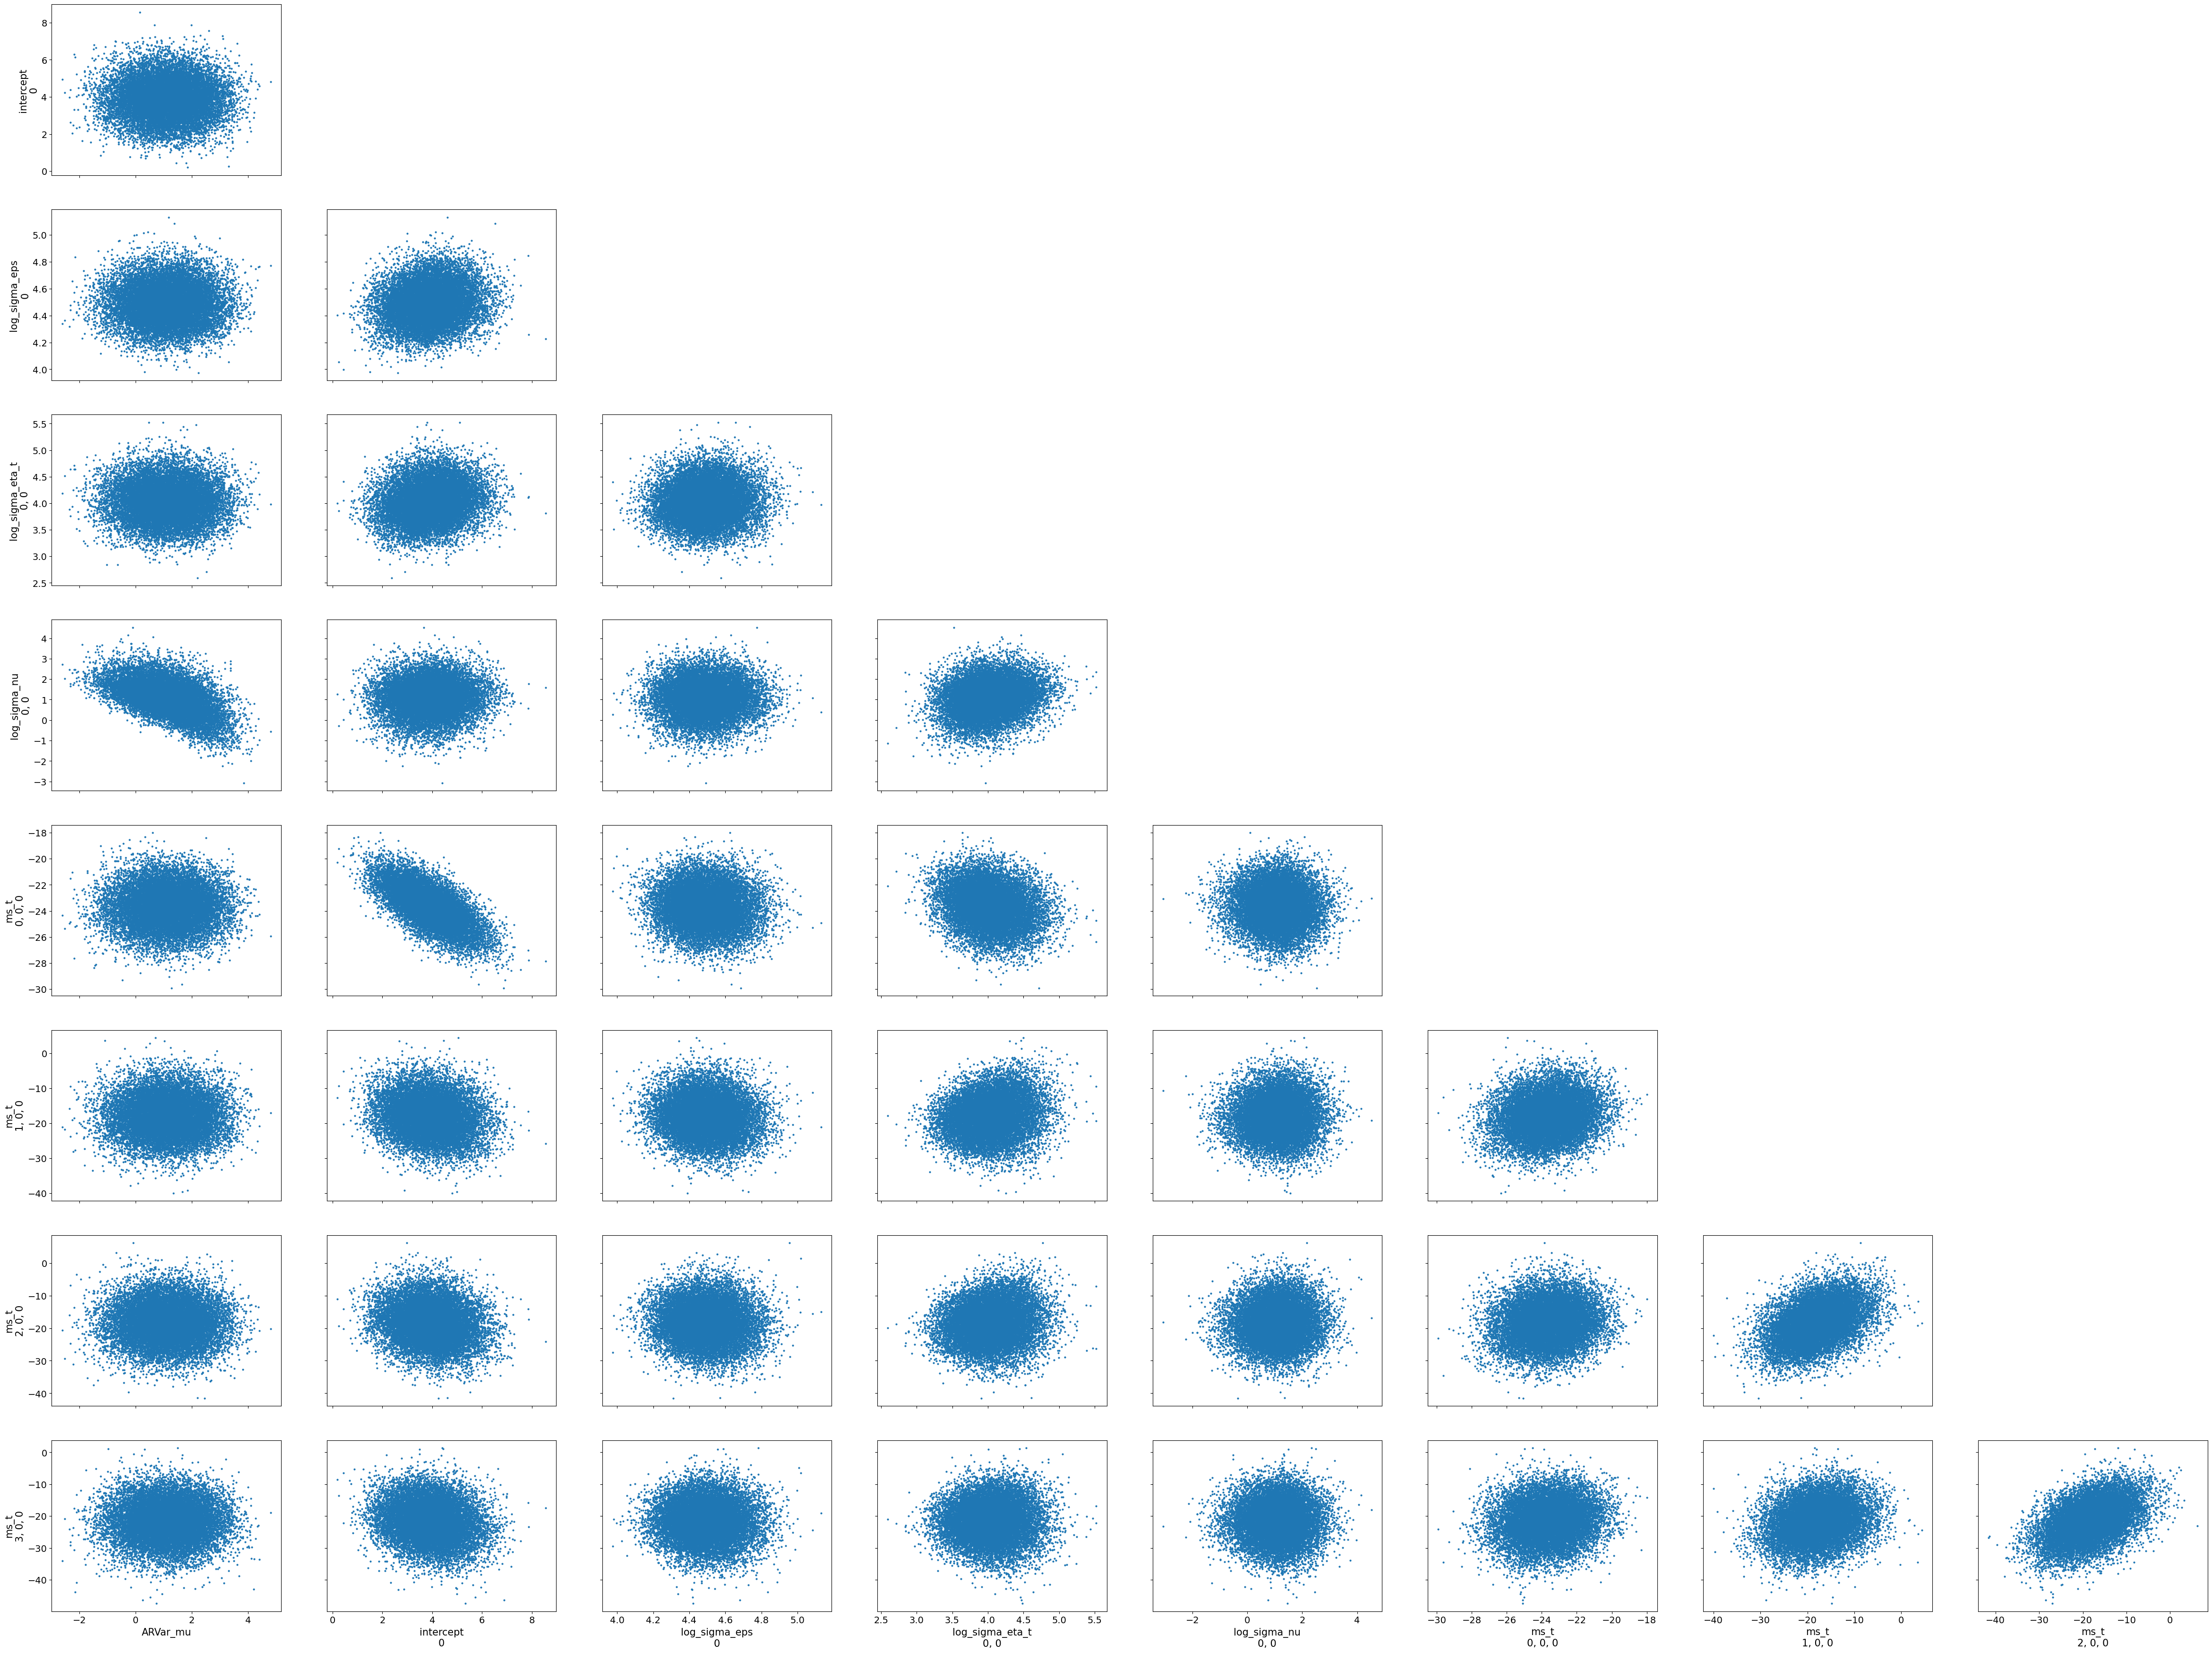

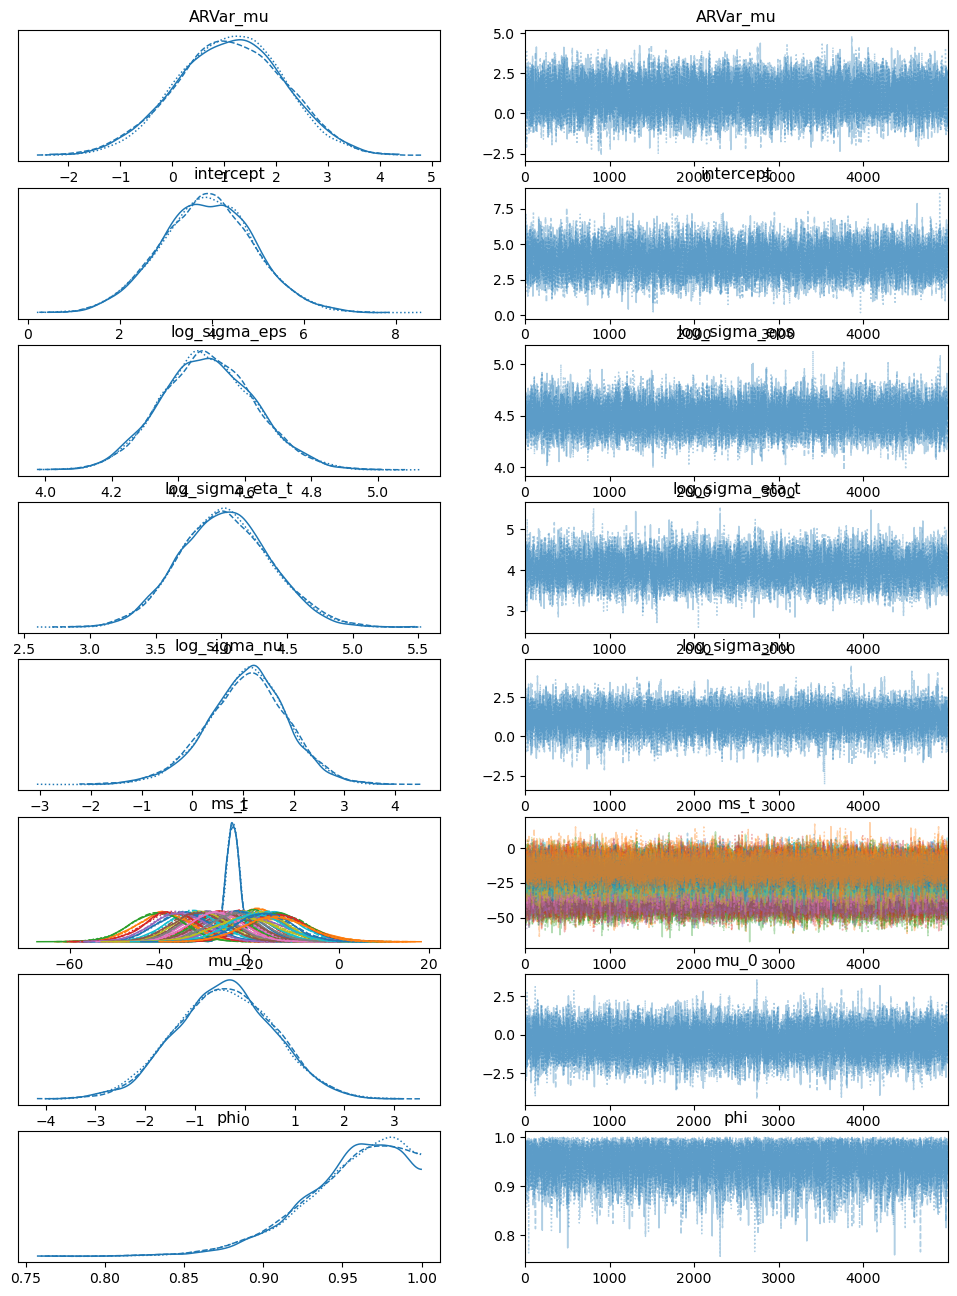

In [6]:
model1 = 'COVIDhub-4_week_ensemble'
model2 = 'COVIDhub-baseline'
val = 'diff'
mean_axis = 'both'
p=1
q=1
ar_constraint='[0,1]'
ar_var_constraint='[0,1]'
sigma_type = 'constant'

obs = loaddata(model1, model2, val, mean_axis)
# Define a DFA model with specified parameter values to use for data generation
dfa_model = ARHDFA(num_timesteps=obs.shape[0], num_series=obs.shape[1], num_horizons=obs.shape[2], 
                    p=p, q=q, ar_constraint=ar_constraint, sigma_type=sigma_type,
                    ar_var_constraint=ar_var_constraint)
mcmc_samples = dfa_model.fit(y=obs,
                            rng_key=jax.random.PRNGKey(79942),
                            num_warmup=5000,
                            num_samples=5000,
                            thinning = 1,
                            num_chains=3)

dfa_model.mcmc.print_summary()
waic = az.waic(az.from_numpyro(mcmc_samples))
print(waic)
az.plot_pair(az.from_numpyro(mcmc_samples),
        #var_names=['intercept', 'alpha', 'phi','ARVar_mu'],
        divergences=True,
        colorbar=True)
az.plot_trace(az.from_numpyro(mcmc_samples))


In [7]:
samples = mcmc_samples.get_samples()
keys = list(samples.keys())
print(keys)

# Iterate through the keys and print the shape of each corresponding array
for key in keys:
    print(samples[key].shape)

['ARVar_mu', 'intercept', 'log_sigma_eps', 'log_sigma_eta_t', 'log_sigma_nu', 'ms_t', 'mu_0', 'phi']
(15000,)
(15000, 1)
(15000, 1)
(15000, 1, 1)
(15000, 1, 1)
(15000, 42, 1, 1)
(15000, 1, 1)
(15000, 1, 1)


[nan nan nan nan]


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_77699/3263566727.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mydf = jnp.array(df_pivot.groupby(level=0, axis=1).agg(lambda x: [*x.values]).to_numpy().tolist())
/Users/dk29776/Dropbox/epi/Comparing-Forecast-Performance/DFA/arhdfa_l1h1.py:357: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 10000/10000 [00:01<00:00, 5954.28it/s, 7 steps of size 2.99e-01. acc. prob=0.89]



MCMC elapsed time: 7.812417984008789

                          mean       std    median      5.0%     95.0%     n_eff     r_hat
            ARVar_mu      1.11      1.02      1.12     -0.58      2.81  21174.49      1.00
        intercept[0]      3.91      1.01      3.91      2.19      5.54   9344.57      1.00
    log_sigma_eps[0]      4.49      0.14      4.49      4.25      4.72  20081.00      1.00
log_sigma_eta_t[0,0]      4.03      0.35      4.02      3.46      4.61   5305.61      1.00
   log_sigma_nu[0,0]      1.08      0.81      1.10     -0.26      2.37  16224.97      1.00
         ms_t[0,0,0]    -23.66      1.47    -23.66    -26.11    -21.31  11494.91      1.00
         ms_t[1,0,0]    -18.07      5.38    -18.13    -26.97     -9.35  19375.71      1.00
         ms_t[2,0,0]    -18.40      5.78    -18.49    -27.88     -8.95  16602.98      1.00
         ms_t[3,0,0]    -21.60      5.81    -21.62    -30.66    -11.70  15775.40      1.00
         ms_t[4,0,0]    -25.69      5.90    -25.64 

/Users/dk29776/miniconda3/envs/forecastskill/lib/python3.10/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 15000 posterior samples and 117 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -433.89     6.28
p_waic        7.80        -

There has been a warning during the calculation. Please check the results.


/Users/dk29776/miniconda3/envs/forecastskill/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


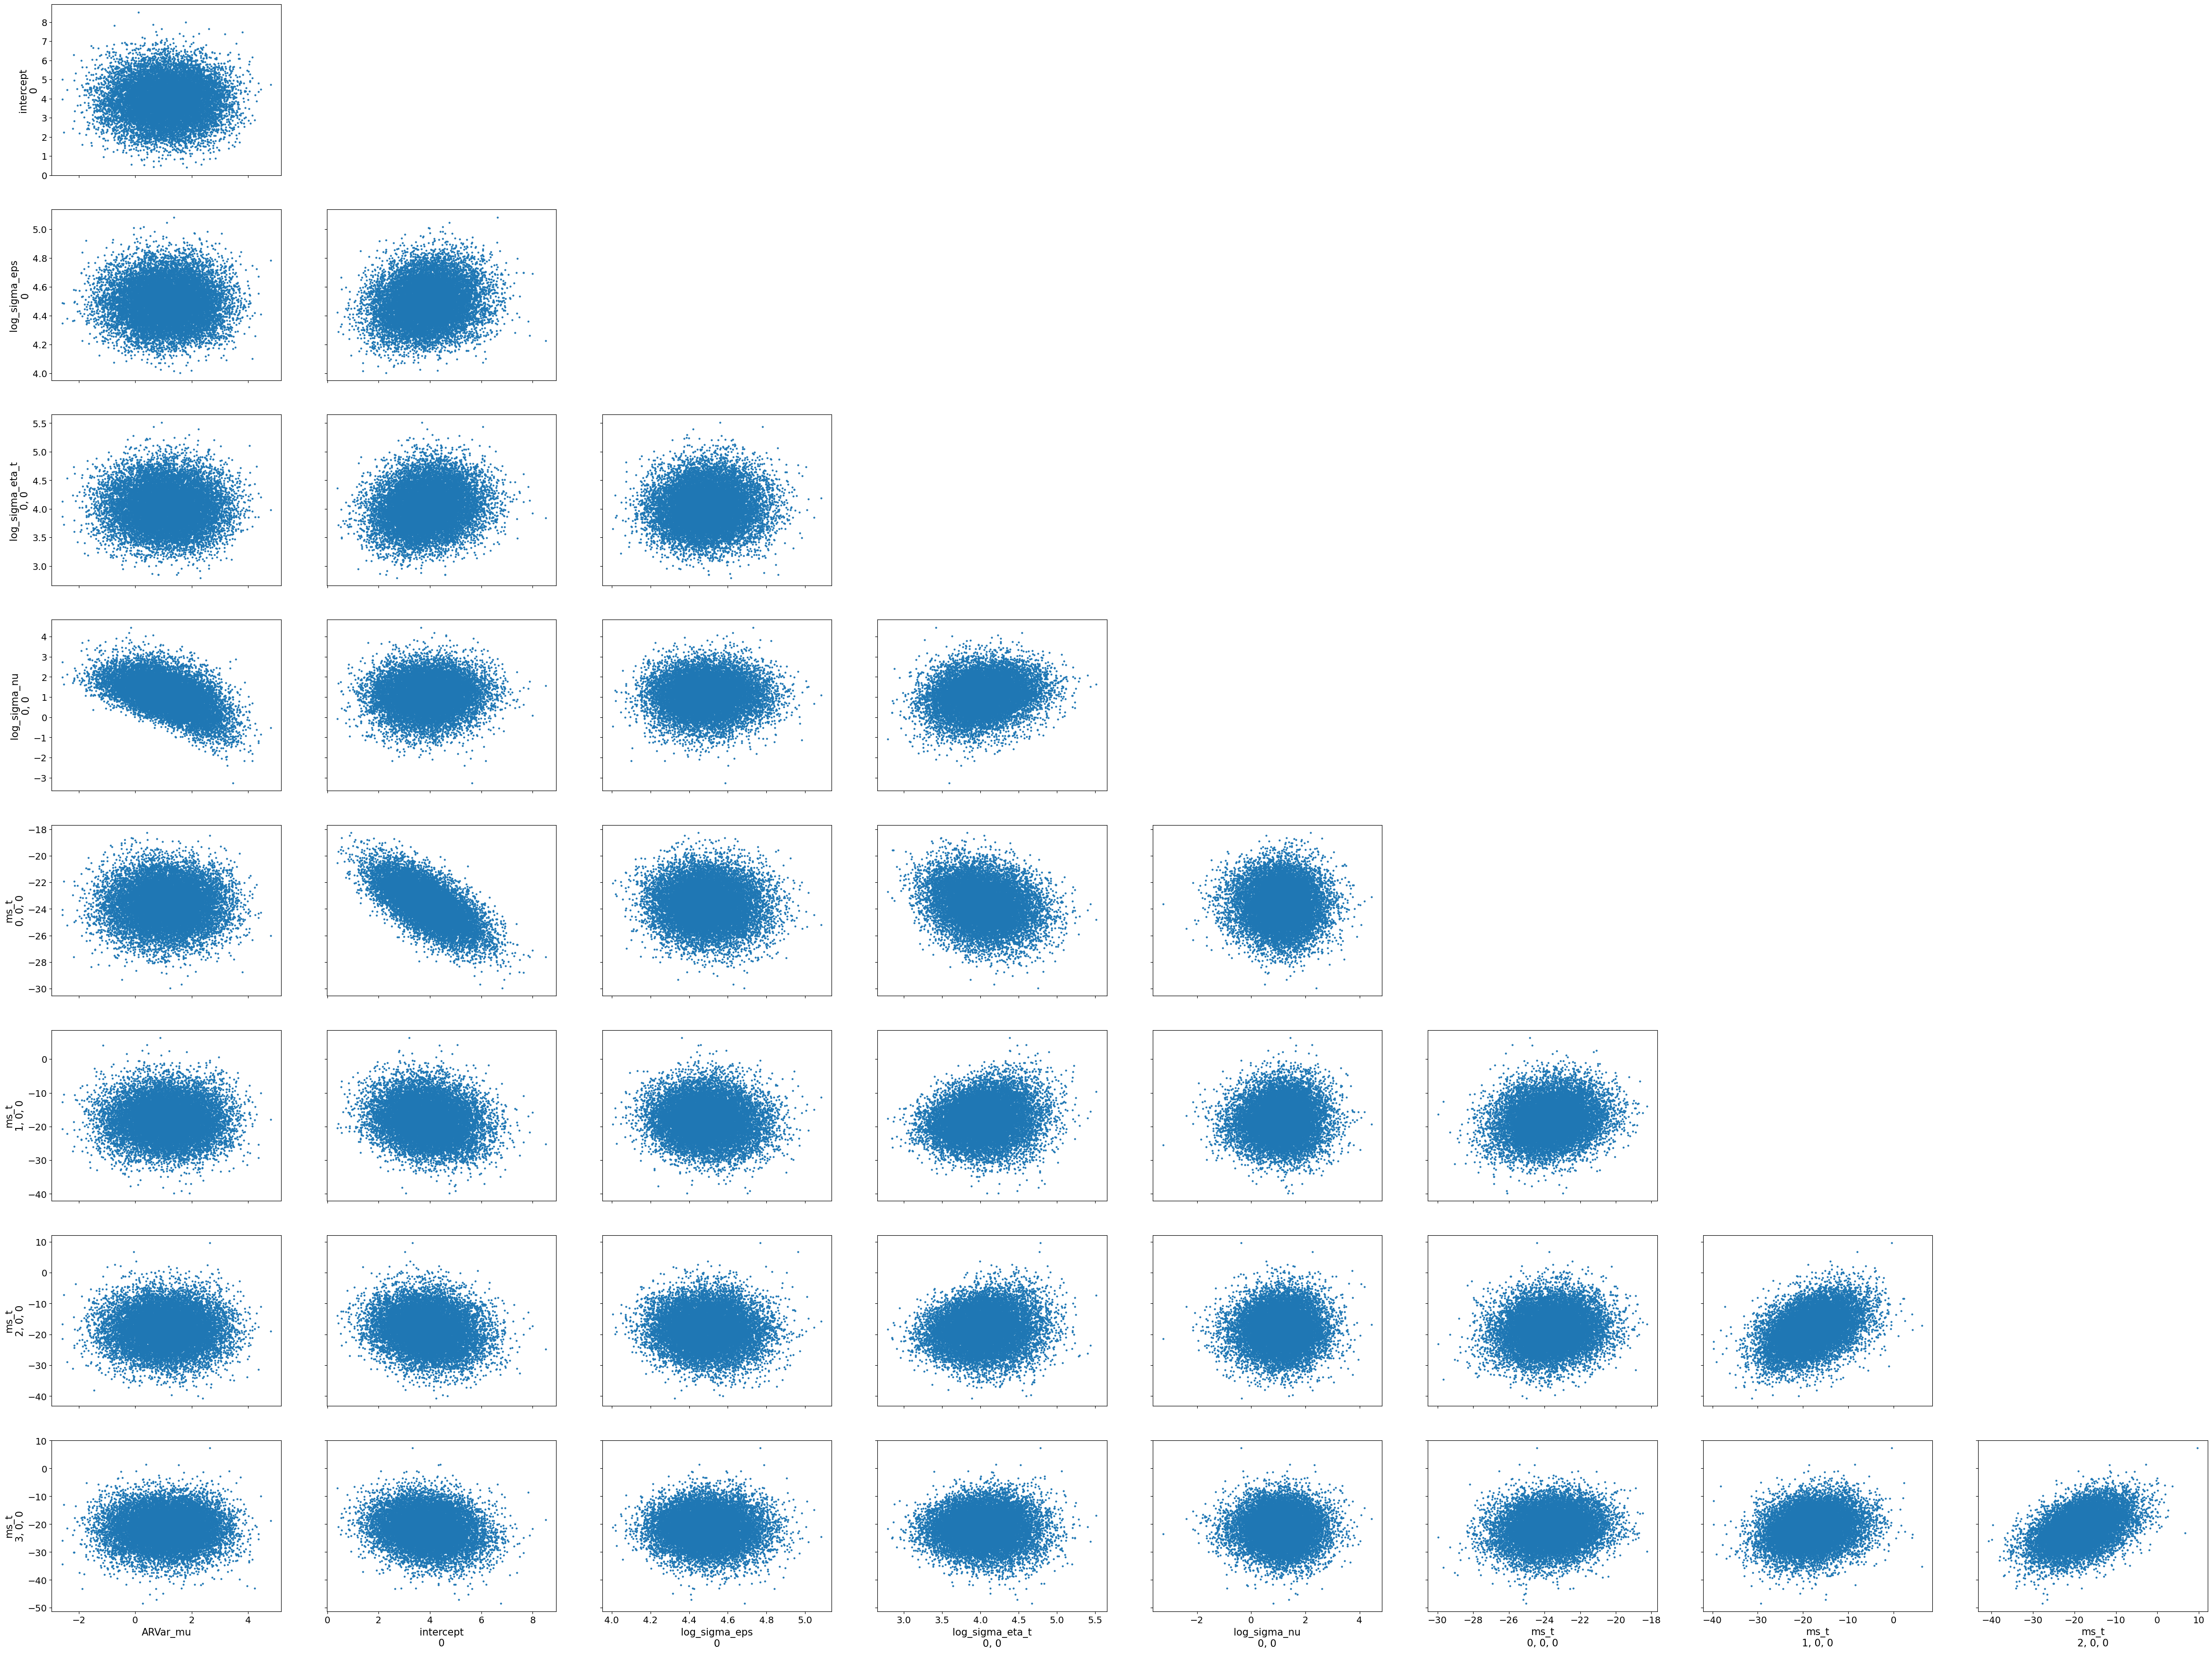

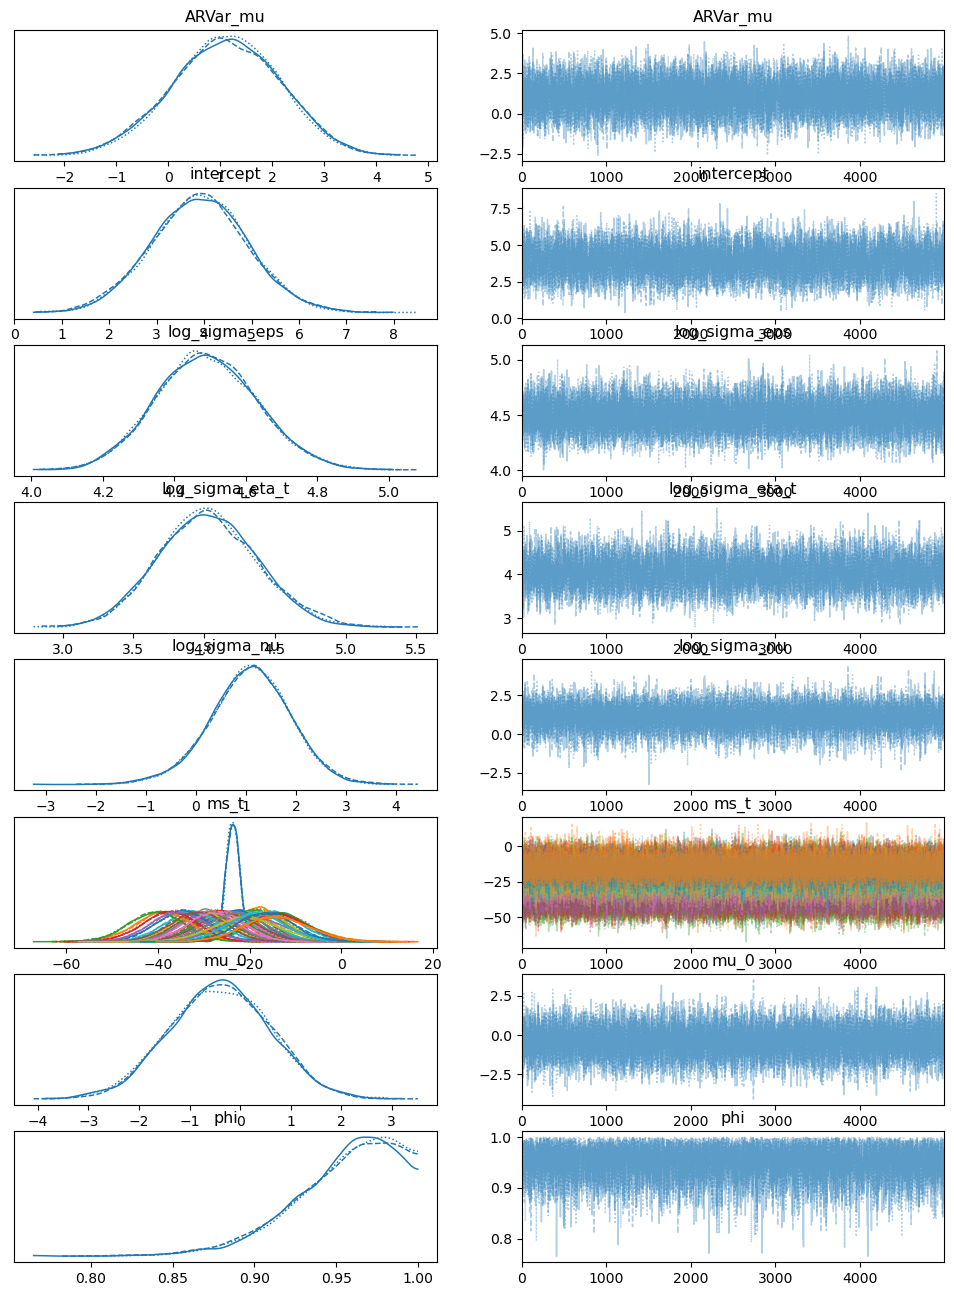

In [8]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=1, q=1, sigma_type = 'constant', ar_constraint='[-1,1]')

/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_77699/3263566727.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mydf = jnp.array(df_pivot.groupby(level=0, axis=1).agg(lambda x: [*x.values]).to_numpy().tolist())
/Users/dk29776/Dropbox/epi/Comparing-Forecast-Performance/DFA/arhdfa_l1h1.py:357: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = numpyro.infer.MCMC(


[nan nan nan nan]


sample: 100%|██████████| 10000/10000 [00:02<00:00, 4410.77it/s, 31 steps of size 9.54e-02. acc. prob=0.95]



MCMC elapsed time: 10.473389148712158

                          mean       std    median      5.0%     95.0%     n_eff     r_hat
            ARVar_mu      1.11      1.03      1.11     -0.56      2.83  10364.43      1.00
        intercept[0]      3.98      1.03      3.98      2.25      5.62   5463.34      1.00
    log_sigma_eps[0]      4.50      0.14      4.50      4.27      4.73  11055.74      1.00
log_sigma_eta_t[0,0]      4.10      0.35      4.10      3.52      4.66   4610.41      1.00
   log_sigma_nu[0,0]      1.11      0.81      1.14     -0.15      2.51   9521.31      1.00
         ms_t[0,0,0]    -23.81      1.48    -23.81    -26.28    -21.43   6810.09      1.00
         ms_t[1,0,0]    -14.02      6.04    -14.10    -24.20     -4.39   7675.00      1.00
         ms_t[2,0,0]    -18.81      5.88    -18.83    -28.56     -9.21  10636.37      1.00
         ms_t[3,0,0]    -20.60      6.08    -20.57    -31.29    -11.33   8958.28      1.00
         ms_t[4,0,0]    -24.76      5.96    -24.73

/Users/dk29776/miniconda3/envs/forecastskill/lib/python3.10/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 15000 posterior samples and 117 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -434.63     6.22
p_waic        8.25        -

There has been a warning during the calculation. Please check the results.


/Users/dk29776/miniconda3/envs/forecastskill/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


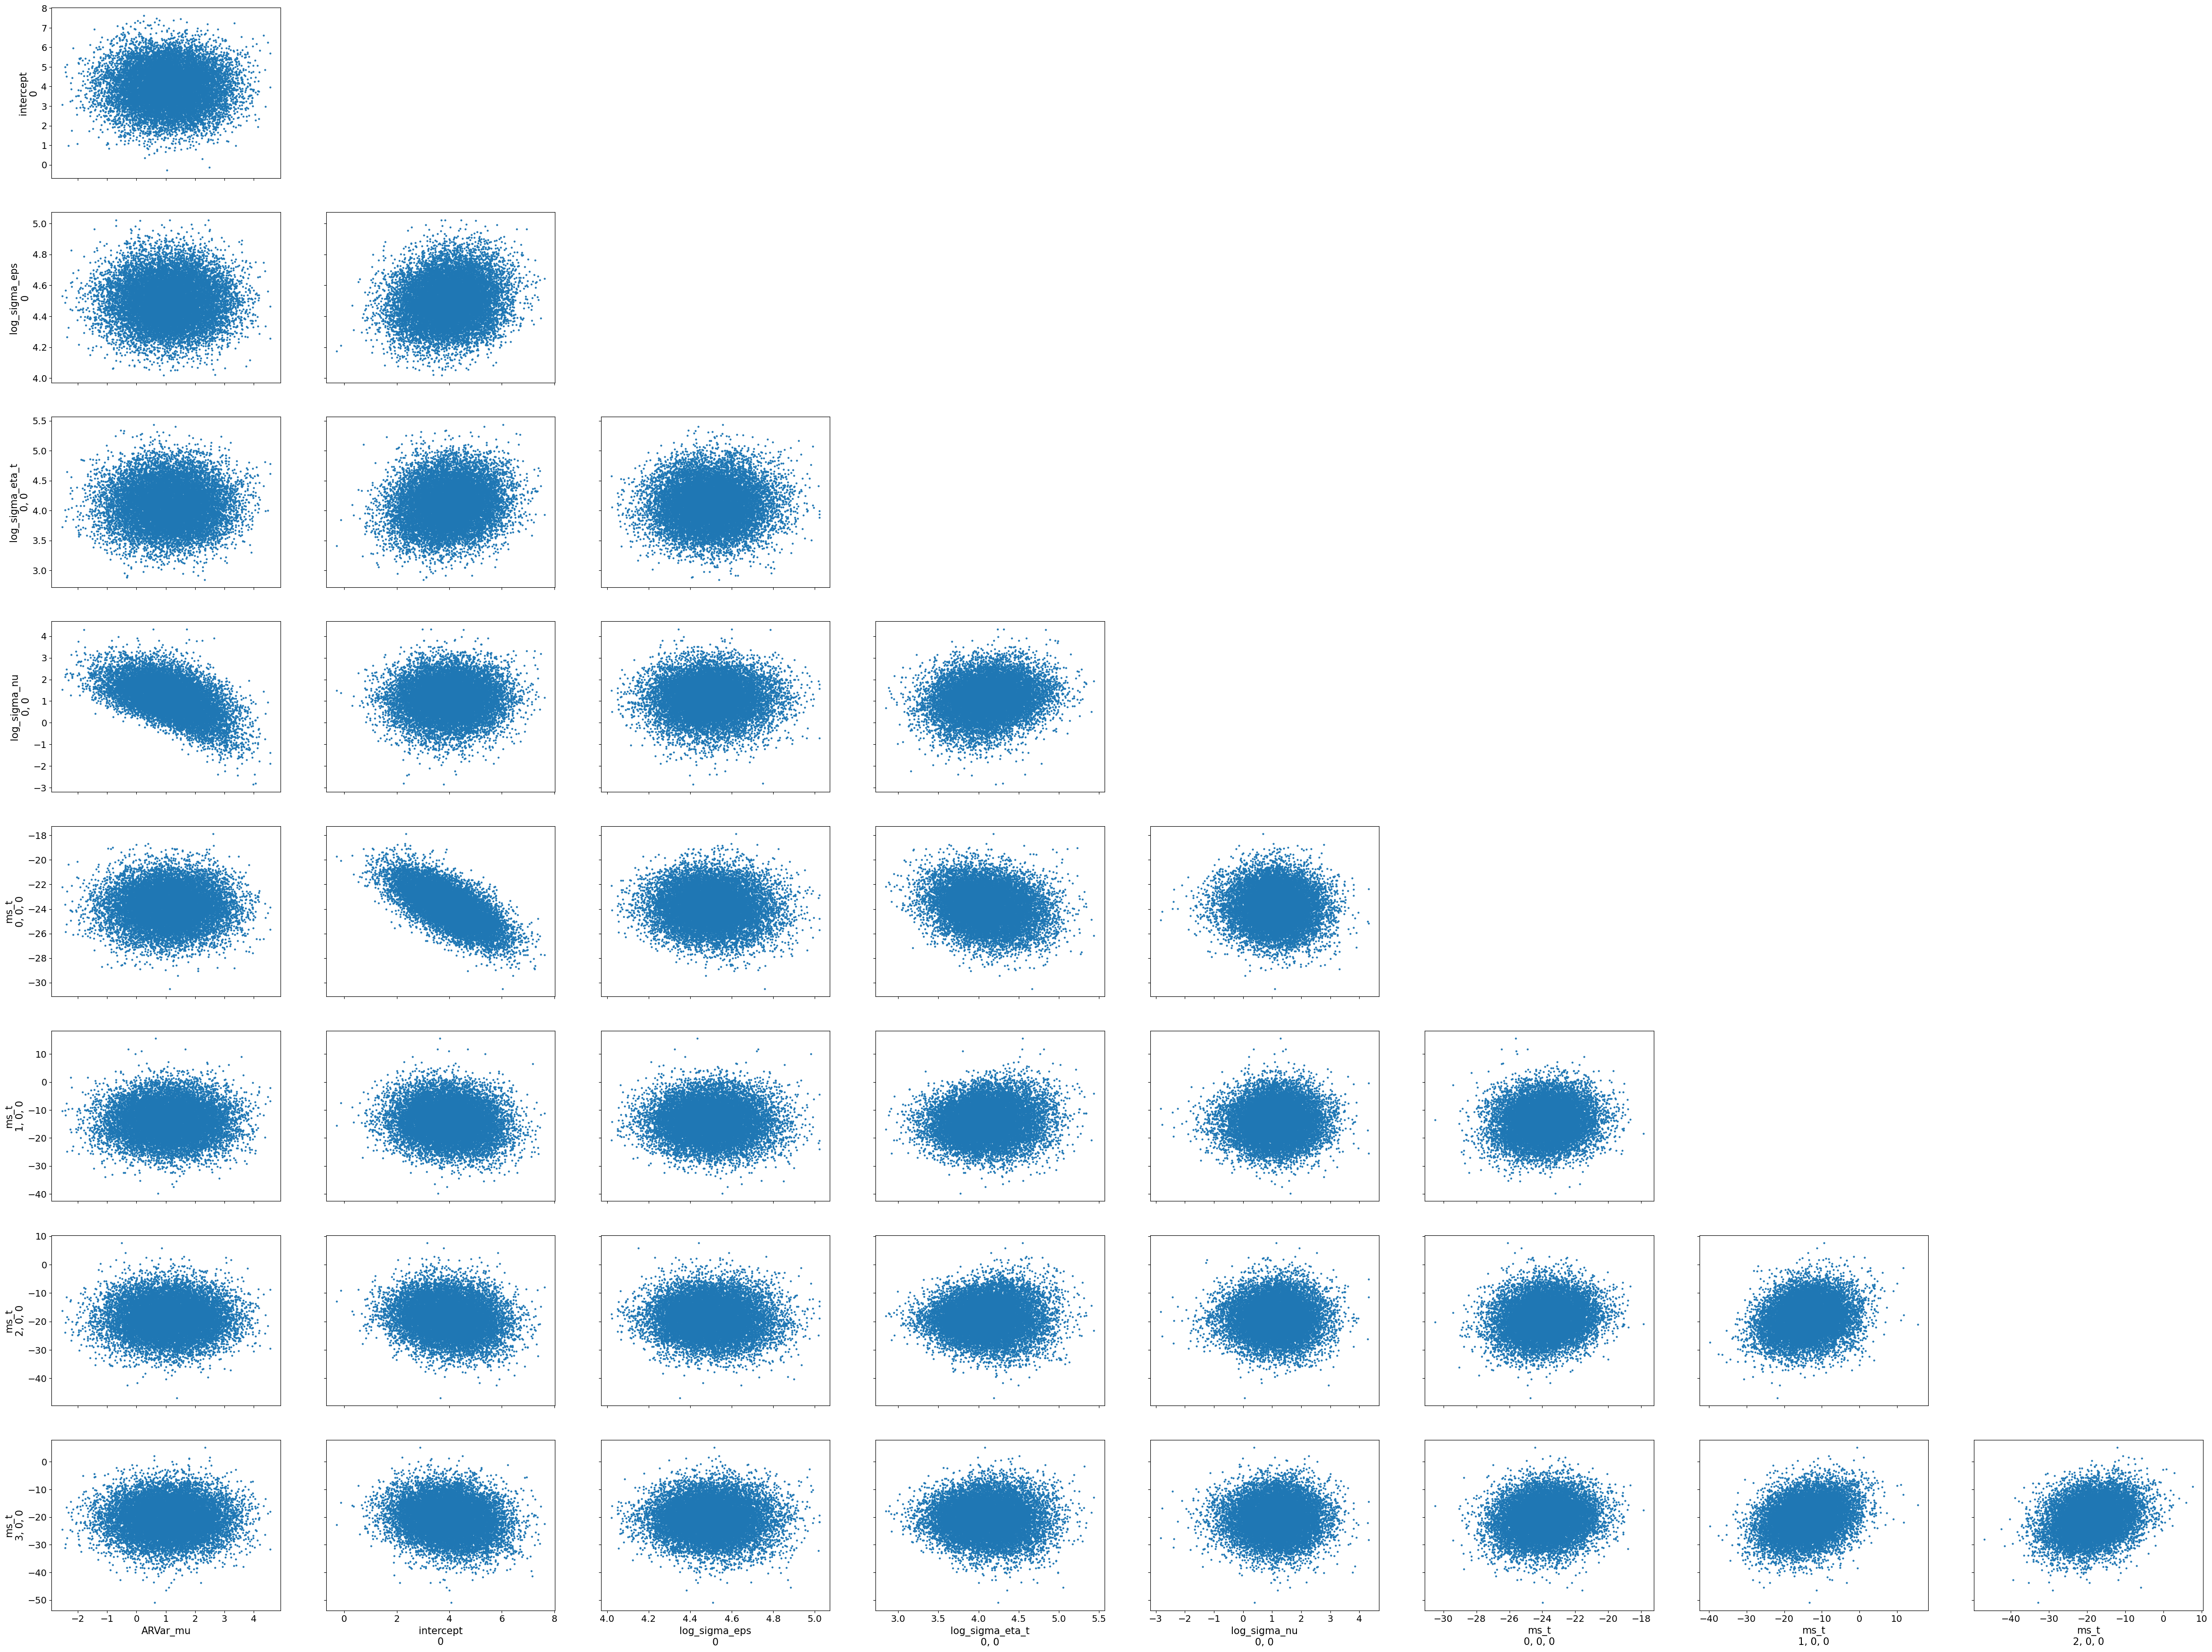

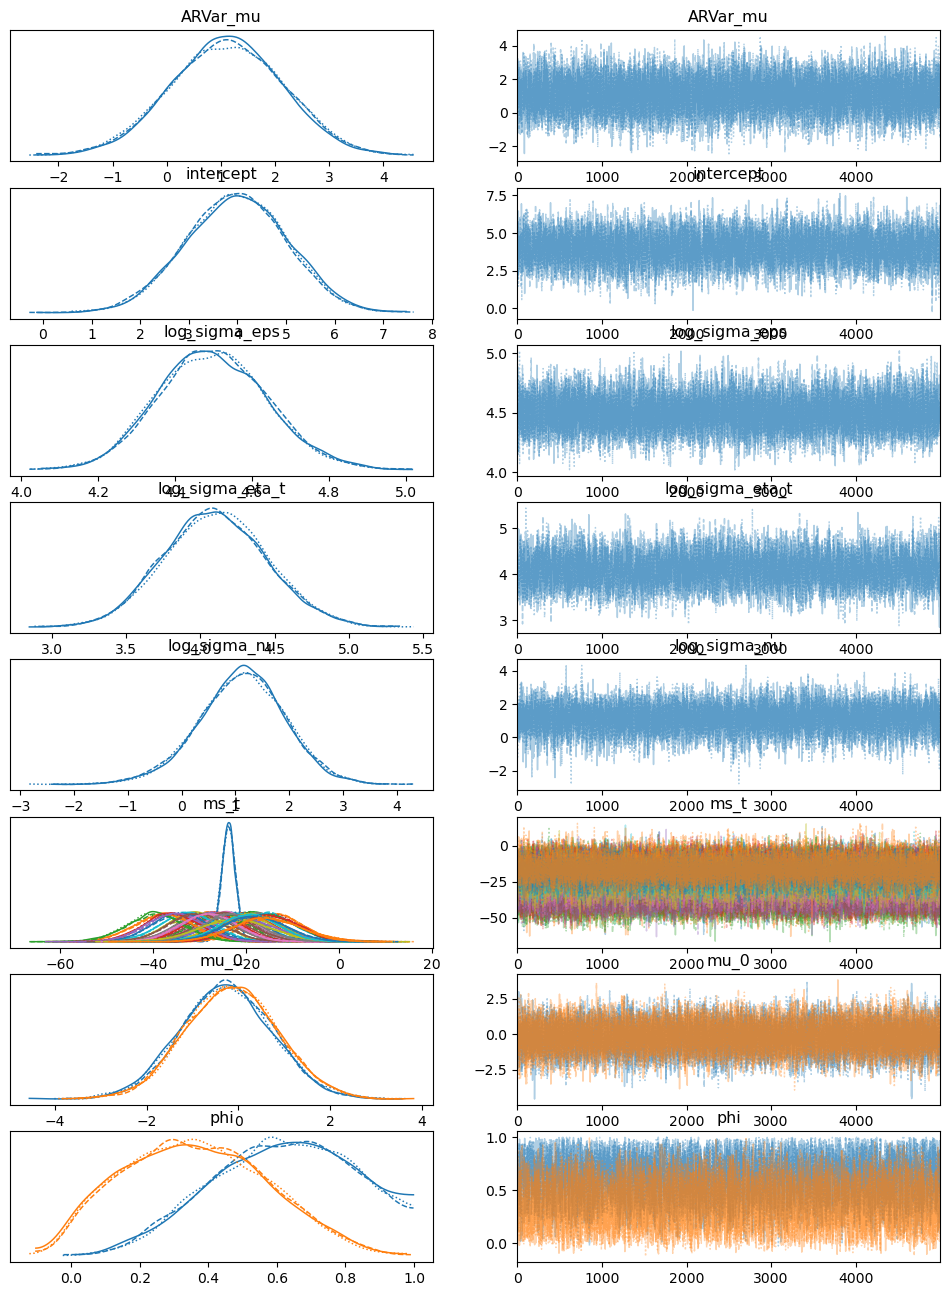

In [9]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=2, q=1, sigma_type = 'constant', ar_constraint='[-1,1]')

In [10]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=3, q=1, sigma_type = 'constant', ar_constraint='[-1,1]')

/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_77699/3263566727.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mydf = jnp.array(df_pivot.groupby(level=0, axis=1).agg(lambda x: [*x.values]).to_numpy().tolist())
/Users/dk29776/Dropbox/epi/Comparing-Forecast-Performance/DFA/arhdfa_l1h1.py:357: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = numpyro.infer.MCMC(


[nan nan nan nan]


warmup:   1%|          | 84/10000 [00:00<00:11, 832.22it/s, 511 steps of size 9.80e-02. acc. prob=0.77]

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=4, q=1, sigma_type = 'constant', ar_constraint='[-1,1]')

## sigma_type = 'AR'

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=1, q=1, sigma_type = 'AR')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=1, q=1, sigma_type = 'AR', ar_var_constraint='[-1,1]')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=2, q=2, sigma_type = 'AR', ar_constraint='[-1,1]')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=2, q=2, sigma_type = 'AR')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=4, q=1, sigma_type = 'AR', ar_constraint='[-1,1]')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=1, q=1, 
        sigma_type = 'AR', ar_constraint='[-1,1]', ar_var_constraint='[-1,1]')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=1, q=2, 
        sigma_type = 'AR', ar_constraint='[-1,1]', ar_var_constraint='[-1,1]')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=1, q=3, 
        sigma_type = 'AR', ar_constraint='[-1,1]', ar_var_constraint='[-1,1]')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=1, q=4, 
        sigma_type = 'AR', ar_constraint='[-1,1]', ar_var_constraint='[-1,1]')